DT Class


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter

# DT node class
class DecisionTreeNode:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

# DT
class DecisionTree:
    def __init__(self, max_depth=None):
        self.root = None
        self.max_depth = max_depth

    def _find_best_split(self, X, y):
        best_feature, best_threshold = None, None
        min_mse = float('inf')

        for feature_index in range(X.shape[1]):
            thresholds = np.unique(X[:, feature_index])

            for threshold in thresholds:
                left_indices = X[:, feature_index] < threshold
                right_indices = X[:, feature_index] >= threshold

                left_mse = self._mse(y[left_indices])
                right_mse = self._mse(y[right_indices])

                mse = (left_mse * len(y[left_indices]) + right_mse * len(y[right_indices])) / len(y)

                if mse < min_mse:
                    min_mse = mse
                    best_feature = feature_index
                    best_threshold = threshold

        return best_feature, best_threshold

    #recursively building the tree
    def _build_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape
        num_labels = len(np.unique(y))

        if num_samples <= 1 or depth >= self.max_depth or num_labels == 1:
            return DecisionTreeNode(value=np.mean(y))

        best_feature, best_threshold = self._find_best_split(X, y)

        left_indices = X[:, best_feature] < best_threshold
        right_indices = X[:, best_feature] >= best_threshold

        left_subtree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return DecisionTreeNode(best_feature, best_threshold, left_subtree, right_subtree)

    #train the model
    def fit(self, X, y):
        self.root = self._build_tree(X, y)

    def _mse(self, y):
        return np.mean((y - np.mean(y)) ** 2)

    def _traverse_tree(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature_index] < node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

Random Forest Algorithm

In [3]:
class RandomForest:
    def __init__(self, n_estimators=100, max_depth=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        n_samples, n_features = X.shape

        for _ in range(self.n_estimators):
            bootstrap_indices = np.random.choice(np.arange(n_samples), size=n_samples, replace=True)
            X_subset = X[bootstrap_indices]
            y_subset = y[bootstrap_indices]
            features_indices = np.random.choice(np.arange(n_features), size=int(np.sqrt(n_features)), replace=False)

            tree = DecisionTree(max_depth=self.max_depth)
            tree.fit(X_subset[:, features_indices], y_subset)
            self.trees.append((tree, features_indices))

    def predict(self, X):
        predictions = np.array([tree.predict(X[:, features_indices]) for tree, features_indices in self.trees])
        return np.mean(predictions, axis=0)

Prediction using DT

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

data = pd.read_csv('/content/drive/MyDrive/2016-09/SL_DataSet/BTC-USD.csv')
data['Date'] = pd.to_datetime(data['Date'])

# fill missing values
data.fillna(data.mean(), inplace=True)

features = data[['Open', 'High', 'Low', 'Volume']]
target = data['Close']
dates = data['Date']
X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(
    features, target, dates, test_size=0.2, random_state=42
)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

# make an instance of a decision tree
tree = DecisionTree(max_depth=5)
tree.fit(X_train, y_train)
predictions = tree.predict(X_test)
mse = np.mean((predictions - y_test) ** 2)
print("Mean Squared Error:", mse)

DT plot 1 : Predictions and actual data aganist time

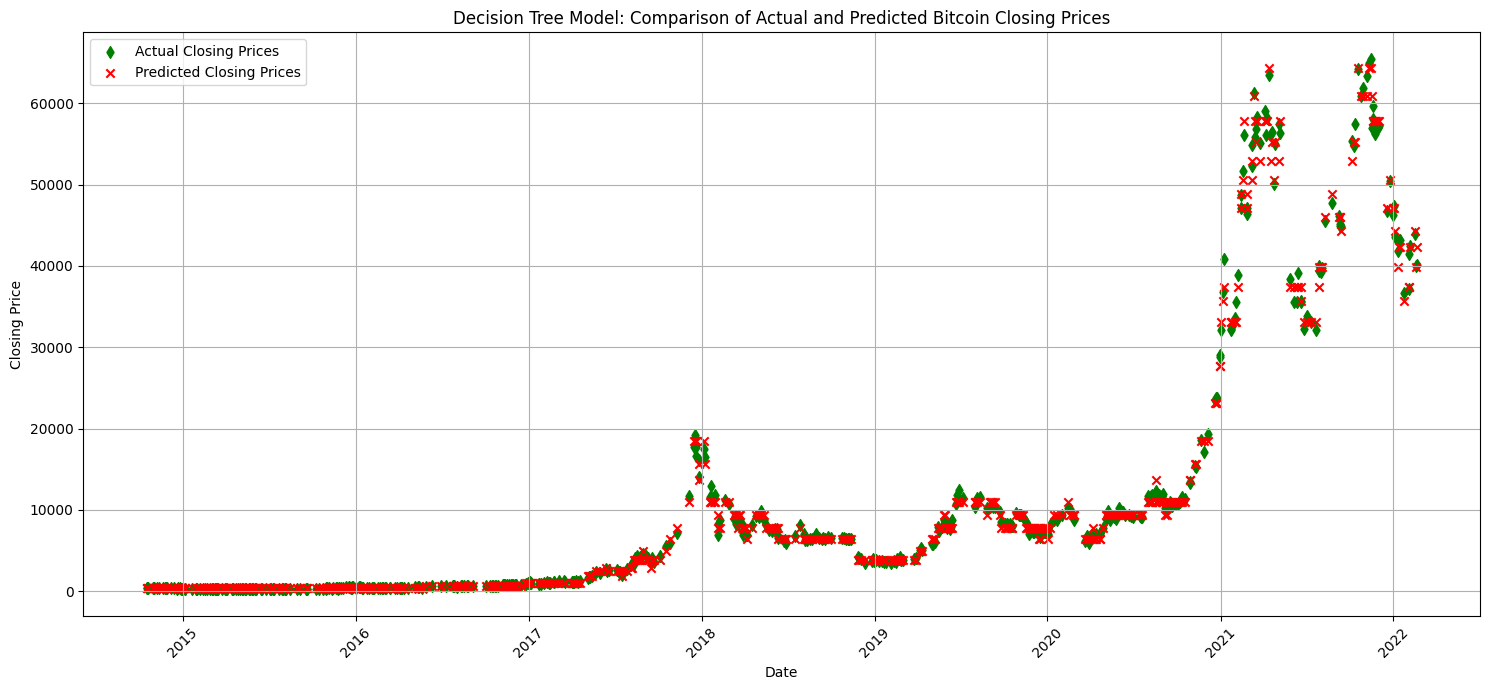

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

data_to_plot = pd.DataFrame({
    'Date': dates_test,
    'Actual': y_test,
    'Predicted': predictions
})

data_to_plot.sort_values('Date', inplace=True)
plt.figure(figsize=(15, 7))
plt.scatter(data_to_plot['Date'], data_to_plot['Actual'], color='green', label='Actual Closing Prices', marker='d')
plt.scatter(data_to_plot['Date'], data_to_plot['Predicted'], color='red', label='Predicted Closing Prices', marker='x')

plt.title('Decision Tree Model: Comparison of Actual and Predicted Bitcoin Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Error Analysis on DT

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae_dt = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error (MAE): {mae_dt}')
mse_dt = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error (MSE): {mse_dt}')
rmse_dt = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse_dt}')

Mean Absolute Error (MAE): 405.79671856340906
Mean Squared Error (MSE): 484907.4622223362
Root Mean Squared Error (RMSE): 571.3880353338349


Additional Experiments with parameters of DT

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Max depth: 1, MSE: 35473499.82965033
Max depth: 2, MSE: 9087387.817757178
Max depth: 3, MSE: 3348717.4189790674
Max depth: 4, MSE: 1120881.0871880564
Max depth: 5, MSE: 484907.4622223362
Max depth: 10, MSE: 403510.11901124753
Max depth: 15, MSE: 404185.8747974887


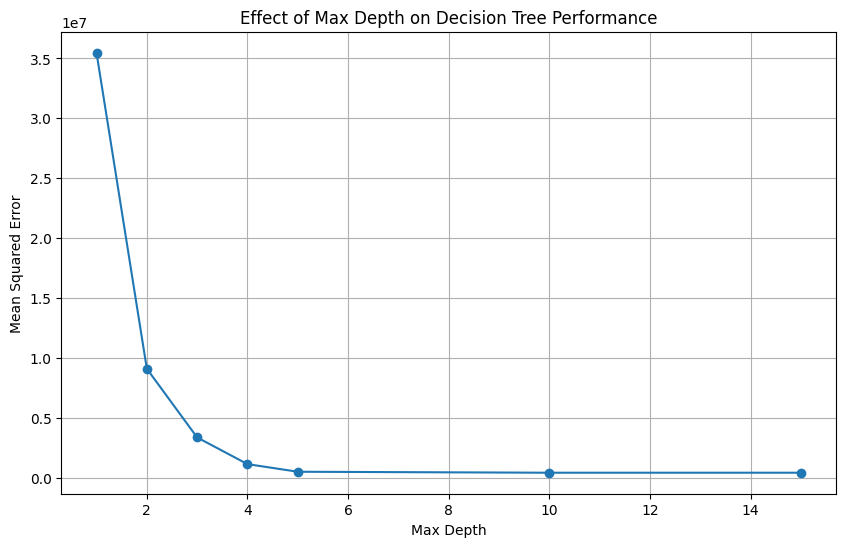

In [18]:
def evaluate_decision_tree(max_depth, X_train, y_train, X_test, y_test):
    tree = DecisionTree(max_depth=max_depth)
    tree.fit(X_train, y_train)
    predictions = tree.predict(X_test)
    mse = np.mean((y_test - predictions) ** 2)
    return mse

depths = [1, 2, 3, 4, 5, 10, 15]
mse_results = []
for depth in depths:
    mse = evaluate_decision_tree(depth, X_train, y_train, X_test, y_test)
    mse_results.append(mse)
    print(f"Max depth: {depth}, MSE: {mse}")

plt.figure(figsize=(10, 6))
plt.plot(depths, mse_results, marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Mean Squared Error')
plt.title('Effect of Max Depth on Decision Tree Performance')
plt.grid(True)
plt.show()

Plot 2: Plotting purely Actual Vs Predicted for DT

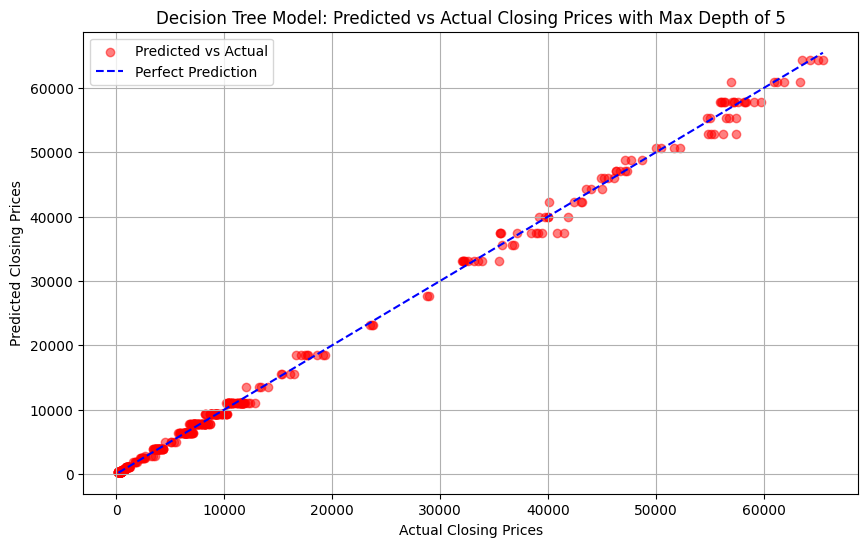

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5, color='red', label='Predicted vs Actual')
plt.title('Decision Tree Model: Predicted vs Actual Closing Prices with Max Depth of 5')
plt.xlabel('Actual Closing Prices')
plt.ylabel('Predicted Closing Prices')
plt.grid(True)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='blue', linestyle='--', label='Perfect Prediction')
plt.legend()
plt.show()


RF Predictions

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

data = pd.read_csv('/content/drive/MyDrive/2016-09/SL_DataSet/BTC-USD.csv')
data['Date'] = pd.to_datetime(data['Date'])

# fill missing values
data.fillna(data.mean(), inplace=True)

features = data[['Open', 'High', 'Low', 'Volume']]
target = data['Close']
dates = data['Date']
X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(
    features, target, dates, test_size=0.2, random_state=42
)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

# make an instance of a decision tree
rf = RandomForest(n_estimators=100, max_depth=5)
rf.fit(X_train, y_train)
predictions_rf = rf.predict(X_test)
mse = np.mean((predictions_rf - y_test) ** 2)
print("Mean Squared Error:", mse)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Mean Squared Error: 312616.1831396372


RF Error Calculations

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, predictions_rf)
print(f'Mean Absolute Error (MAE): {mae}')
mse = mean_squared_error(y_test, predictions_rf)
print(f'Mean Squared Error (MSE): {mse}')
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 324.5083015318637
Mean Squared Error (MSE): 312616.1831396372
Root Mean Squared Error (RMSE): 559.1209020772137


Plotting RF

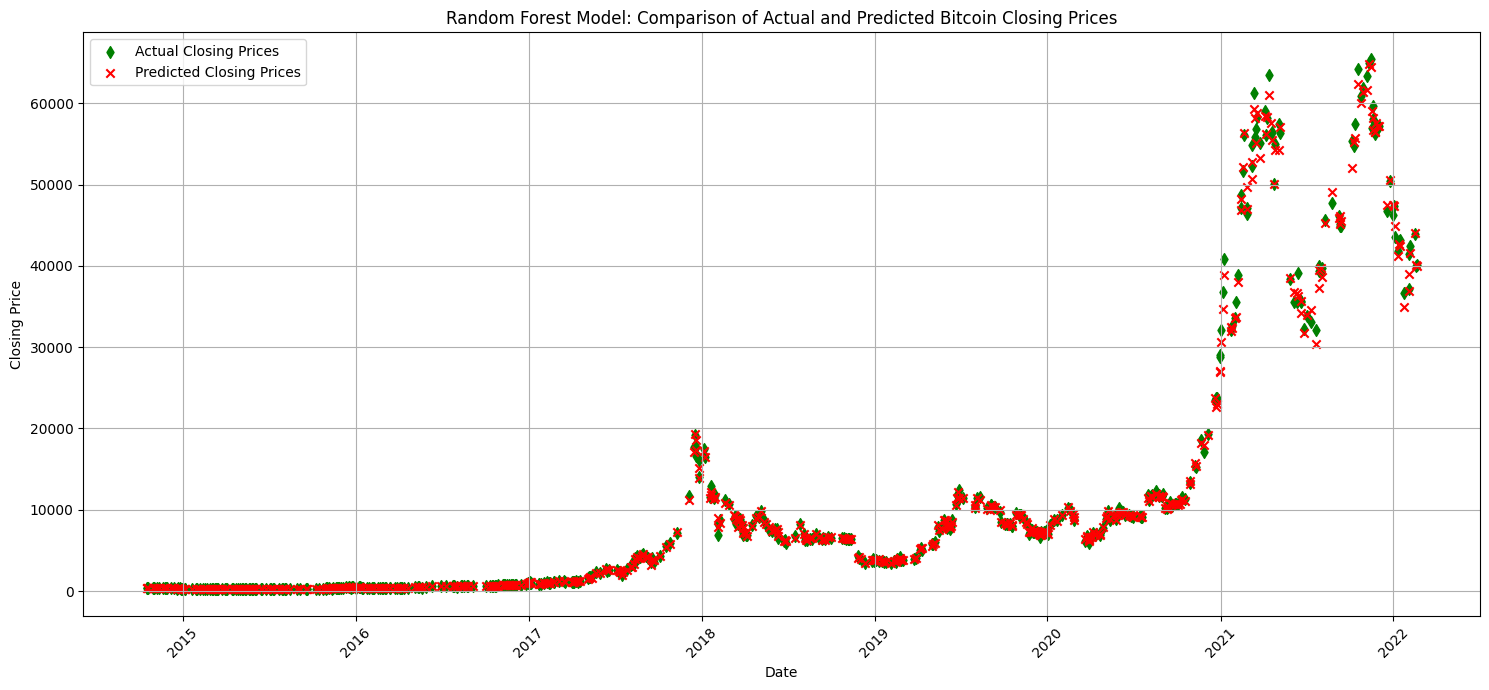

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

data_to_plot = pd.DataFrame({
    'Date': dates_test,
    'Actual': y_test,
    'Predicted': predictions_rf
})

data_to_plot.sort_values('Date', inplace=True)
plt.figure(figsize=(15, 7))
plt.scatter(data_to_plot['Date'], data_to_plot['Actual'], color='green', label='Actual Closing Prices', marker='d')
plt.scatter(data_to_plot['Date'], data_to_plot['Predicted'], color='red', label='Predicted Closing Prices', marker='x')

plt.title('Random Forest Model: Comparison of Actual and Predicted Bitcoin Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Plot 2: RF

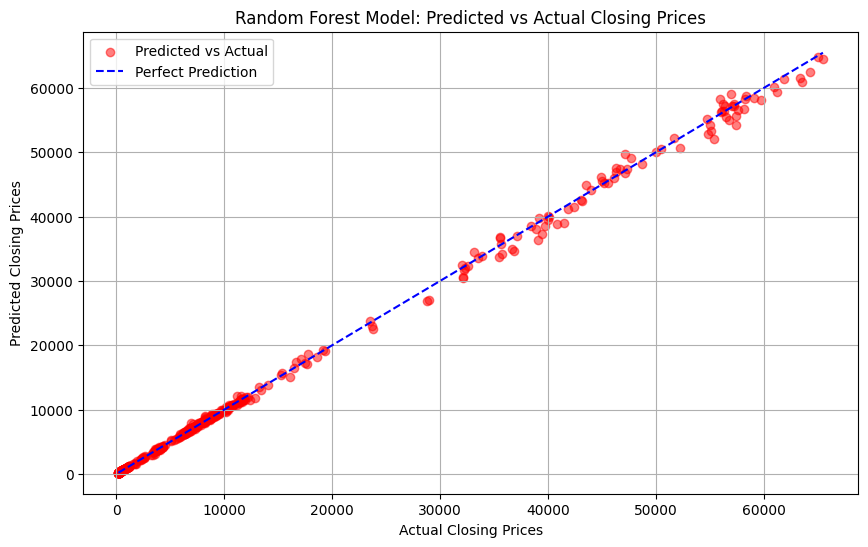

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions_rf, alpha=0.5, color='red', label='Predicted vs Actual')
plt.title('Random Forest Model: Predicted vs Actual Closing Prices')
plt.xlabel('Actual Closing Prices')
plt.ylabel('Predicted Closing Prices')
plt.grid(True)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='blue', linestyle='--', label='Perfect Prediction')
plt.legend()
plt.show()


Additional Experiments with parameters of RF

In [20]:
def evaluate_RF(max_depth, n_estimators_options, X_train, y_train, X_test, y_test):
    rf = RandomForest(n_estimators=n_estimators_options, max_depth=max_depth)
    rf.fit(X_train, y_train)
    predictions_rf = rf.predict(X_test)
    mse = np.mean((y_test - predictions_rf) ** 2)
    return mse

n_estimators_options = [10, 50, 100, 200]
max_depth_options = [1, 5, 10, 20]
results = []
for n_estimators in n_estimators_options:
    for max_depth in max_depth_options:
        rf = RandomForest(n_estimators=n_estimators, max_depth=max_depth)
        rf.fit(X_train, y_train)
        predictions_rf = rf.predict(X_test)
        mse = np.mean((predictions_rf - y_test) ** 2)
        results.append((n_estimators, max_depth, mse))
        print(f"n_estimators: {n_estimators}, max_depth: {str(max_depth)}, MSE: {mse}")

n_estimators: 10, max_depth: 1, MSE: 35420421.97816314
n_estimators: 10, max_depth: 5, MSE: 426929.4166842477
n_estimators: 10, max_depth: 10, MSE: 367229.6599836749
n_estimators: 10, max_depth: 20, MSE: 299800.45701247314
n_estimators: 50, max_depth: 1, MSE: 35279033.88297961
n_estimators: 50, max_depth: 5, MSE: 303113.67606694996
n_estimators: 50, max_depth: 10, MSE: 290077.28669616225
n_estimators: 50, max_depth: 20, MSE: 295559.6443213198
n_estimators: 100, max_depth: 1, MSE: 35342864.99445939
n_estimators: 100, max_depth: 5, MSE: 305451.8401989371
n_estimators: 100, max_depth: 10, MSE: 269271.35188560834
n_estimators: 100, max_depth: 20, MSE: 309233.8520152451
n_estimators: 200, max_depth: 1, MSE: 35395378.54897124
n_estimators: 200, max_depth: 5, MSE: 316962.7061139377
n_estimators: 200, max_depth: 10, MSE: 297184.87065486127
n_estimators: 200, max_depth: 20, MSE: 309357.02912601695


Plotting the results from RF experiments

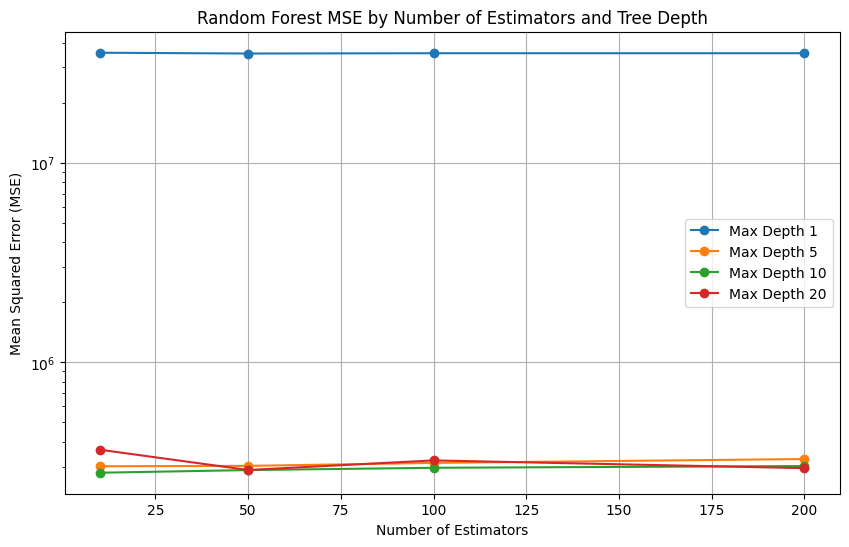

In [23]:
import matplotlib.pyplot as plt
data = [
    (10, 1, 35555089.930713266),
    (10, 5, 300935.8631220693),
    (10, 10, 279308.35607455234),
    (10, 20, 364313.5947658564),
    (50, 1, 35229446.05817294),
    (50, 5, 302283.07747873914),
    (50, 10, 287995.59843029914),
    (50, 20, 288213.6954551179),
    (100, 1, 35353263.66244472),
    (100, 5, 312841.81216985994),
    (100, 10, 295707.1553659534),
    (100, 20, 321957.8444330603),
    (200, 1, 35347994.40301363),
    (200, 5, 327133.969846949),
    (200, 10, 301608.310746054),
    (200, 20, 294417.0084851493)
]

results = {}
for n_estimators, max_depth, mse in data:
    if max_depth not in results:
        results[max_depth] = []
    results[max_depth].append((n_estimators, mse))
plt.figure(figsize=(10, 6))
for max_depth, values in results.items():
    sorted_values = sorted(values)
    plt.plot([v[0] for v in sorted_values], [v[1] for v in sorted_values], label=f'Max Depth {max_depth}', marker='o')

plt.xlabel('Number of Estimators')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Random Forest MSE by Number of Estimators and Tree Depth')
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.show()


Comparison of RF and DT MSE

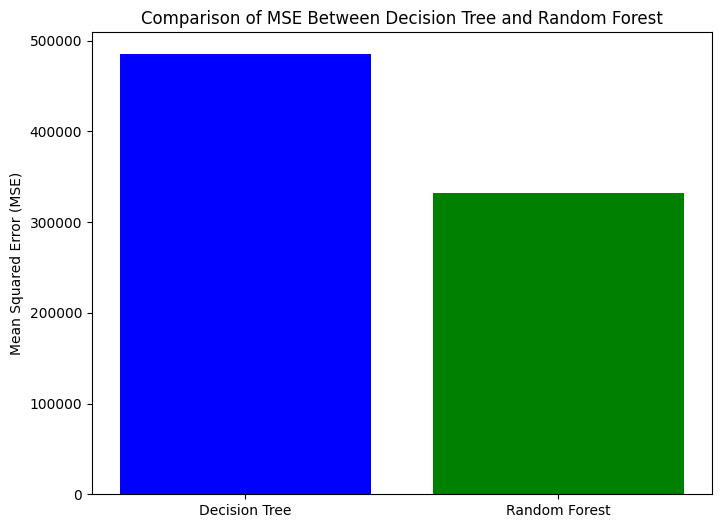

In [24]:
import matplotlib.pyplot as plt

dt_mse = 484907.4622223362
rf_mse = 332098.14582859405

models = ['Decision Tree', 'Random Forest']
mse_values = [dt_mse, rf_mse]
plt.figure(figsize=(8, 6))
plt.bar(models, mse_values, color=['blue', 'green'])
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of MSE Between Decision Tree and Random Forest')
plt.show()